### Area of Medical Services Shortage Classification (Catboost Multi-Class Classifier)

1. Data was first pre-processed and load the final version of la_facility_mua.csv here

2. Since feature engineering has been done, a few touch-ups before training:

a) **Feature Mapping,**

b) **Dropping useless variables,**

c) **Datetime conversion,**

d) **Days Diff**

3. We have 51-classes of Zip Codes. 

a) Group Zip Codes into **10** categories(0-9) based on **Severity of Shortage**

b) **9** represents the **Highest Shortage** while **0** represents the **Lowest Shortage**

c) Name the new variable as **'Zip Class'** which is our **Target** (what we will try to predict here)**

4. Data was split into Train and Validation

5. Model: **CatboostClassifier**

6. 2 Methods:

a) Method-1: Simple train-test-split 

b) Method-2: 6-KFold 

In [2]:
import os
os.environ['PYTHONHASHSEED']='0'

In [3]:
import pandas as pd
import numpy as np
import random as rn
# Deep Learning Libraries
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv1D,MaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import tensorflow as tf
np.random.seed(37)
rn.seed(42)
tf.random.set_seed(42)
from keras import backend as K

Using TensorFlow backend.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from math import sqrt 
from sklearn.metrics import log_loss
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_auc_score
from catboost import CatBoostClassifier,Pool, cv
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

la_facility_mua = pd.read_csv('../input/la-final-data-2/la_facility_mua.csv')

In [5]:
la_facility_mua.head()

,source,cat1,cat2,org_name,Name,addrln1,city,state,post_id,description,...,facility_address_1,MUA_RuralStatus,MUA_Designated_Time,MUA_Designated_Date,MUA_MSSA_Name_1,MUA_Updated_Time,MUA_Updated_Date,MUA_Poverty,MUA_Score,MUA_Pct_100Poverty
0,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,415 South Union Avenue,Urban,1.067990e+12,2003-11-05,MSSA 78.2b (Pico Union/Westlake),1.067990e+12,2003-11-05,157757.0,51.0,0.0
1,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,600 St Paul Ave,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
2,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1125 W 6th St,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
3,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1225 Wilshire Boulevard,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
4,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1127 Wilshire Blvd,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0


In [9]:
zip_score = {
    'MUA_Score': ['mean'],
}
zip_score = la_facility_mua.groupby(['Zip Code']).agg(zip_score)
zip_score.columns = ['ByZipCode_' + ('_'.join(col).strip()) for col in zip_score.columns.values]
zip_score.reset_index(inplace=True)

In [10]:
zip_score = zip_score.sort_values(by=['ByZipCode_MUA_Score_mean'], ascending=True)

In [11]:
zip_score.head()

,Zip Code,ByZipCode_MUA_Score_mean
18,90044,48.350000
7,90013,50.200000
15,90037,50.857143
5,90011,50.914286
2,90006,51.000000


In [12]:
la_facility_mua['Zip Class'] = la_facility_mua['Zip Code'].map({
90044:9, 90013:9, 90037:9, 90011:9, 90006:9,
90002:8, 90059:8, 90047:8, 90255:8, 90018:8,
90007:7, 90221:7, 90003:7, 90015:7, 90010:7,
90012:6, 91601:6, 90220:6, 90057:6, 91606:6,
91767:5, 91768:5, 91766:5, 90043:5, 90302:5,
90033:4, 90262:4, 91770:4, 91731:4, 90248:4,
91205:3, 91101:3, 90026:3, 91605:3, 90017:3,
90813:2, 91340:2, 90802:2, 90805:2, 90806:2,
90020:1, 91331:1, 90042:1, 90031:1, 90250:1,
91401:0, 91405:0, 90731:0, 91406:0, 90744:0, 91411:0})

la_facility_mua['Zip Class'] = la_facility_mua['Zip Class'].astype('int32')

In [13]:
la_facility_mua['Zip Class'].value_counts().sort_values(ascending=False)

0    2094
6    2067
7    1242
2    1230
4    1013
3     961
9     613
1     455
5     453
8     377
Name: Zip Class, dtype: int64

In [14]:
la_facility_mua.rename({'cat1': 'Category Service'}, axis=1, inplace=True)

In [15]:
la_facility_mua['Category Service'].value_counts().sort_values(ascending=False)

Health and Mental Health    4858
Social Services             4330
Public Safety               1317
Name: Category Service, dtype: int64

In [16]:
la_facility_mua['Category Service']=la_facility_mua['Category Service'].map({
'Health and Mental Health':0,
'Social Services':1,
'Public Safety':2
})
la_facility_mua['Category Service']=la_facility_mua['Category Service'].astype('int32')

In [18]:
la_facility_mua['facility_er_service'] = la_facility_mua['facility_er_service'].map({
'Not Applicable':'Not Applicable',
'None':'Not Applicable',
'Emergency - Basic':'Emergency',
'Emergency - Comprehensive':'Emergency',
'Emergency - Standby':'Emergency'
})

In [19]:
la_facility_mua['MUA_Poverty']=la_facility_mua['MUA_Poverty'].map({
157757.0:2,
129447.0:1,
0.0:0,
})

In [24]:
la_facility_mua['MUA_Designated_Date'] = pd.to_datetime(la_facility_mua['MUA_Designated_Date']) 
la_facility_mua['MUA_Updated_Date'] = pd.to_datetime(la_facility_mua['MUA_Updated_Date']) 
la_facility_mua['Date Difference'] = la_facility_mua['MUA_Updated_Date']-la_facility_mua['MUA_Designated_Date']

In [25]:
def ddiff2days(ddiff):
    if not pd.isnull(ddiff):
        return pd.Timedelta.total_seconds(ddiff)/(24.*3600)
    else:
        return np.NaN

In [26]:
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].apply(ddiff2days)
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].astype('int32')

In [27]:
la_facility_mua['design_year'] = (la_facility_mua['MUA_Designated_Date'].dt.year).astype('int32')
la_facility_mua['design_month'] = (la_facility_mua['MUA_Designated_Date'].dt.month).astype('int32')
la_facility_mua['design_week'] = (la_facility_mua['MUA_Designated_Date'].dt.week).astype('int32')
la_facility_mua['design_dow'] = (la_facility_mua['MUA_Designated_Date'].dt.dayofweek).astype('int32')

la_facility_mua['update_year'] = (la_facility_mua['MUA_Updated_Date'].dt.year).astype('int32')
la_facility_mua['update_month'] = (la_facility_mua['MUA_Updated_Date'].dt.month).astype('int32')
la_facility_mua['update_week'] = (la_facility_mua['MUA_Updated_Date'].dt.week).astype('int32')
la_facility_mua['update_dow'] = (la_facility_mua['MUA_Updated_Date'].dt.dayofweek).astype('int32')

In [29]:
la_facility_mua.drop(['MUA_Designated_Date', 'MUA_Updated_Date', 'Zip Code',                  
 ], axis=1, inplace=True)

In [30]:
cols = [c for c in la_facility_mua.columns if la_facility_mua[c].dtypes=='object']
for c in cols:
    le = LabelEncoder()
    la_facility_mua[c] = (le.fit_transform(la_facility_mua[c])).astype('int32')

In [31]:
cat_cols=['city', 'Street']

In [32]:
X = la_facility_mua.drop(labels=['Zip Class'], axis=1)
y = la_facility_mua['Zip Class']

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=tf.random.set_seed(42))

In [33]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations=1500, 
                         learning_rate=0.03,
                         loss_function='MultiClass', 
                         eval_metric='Accuracy', 
                         depth=6,
                         random_seed=42, 
                         od_type='Iter', 
                         )
clf.fit(X_train, y_train, verbose=50,
        use_best_model=True,
        cat_features=cat_cols,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        early_stopping_rounds=33,
        plot=False)

0:	learn: 0.6967504	test: 0.6967504	test1: 0.6924248	best: 0.6924248 (0)	total: 207ms	remaining: 5m 10s
50:	learn: 0.9384362	test: 0.9465600	test1: 0.9429006	best: 0.9429006 (50)	total: 6.02s	remaining: 2m 51s
100:	learn: 0.9744859	test: 0.9809596	test1: 0.9752569	best: 0.9771603 (95)	total: 12.4s	remaining: 2m 51s
150:	learn: 0.9852755	test: 0.9899721	test1: 0.9843928	best: 0.9843928 (150)	total: 19.4s	remaining: 2m 53s
200:	learn: 0.9893374	test: 0.9932724	test1: 0.9881995	best: 0.9881995 (188)	total: 26.3s	remaining: 2m 49s
Stopped by overfitting detector  (33 iterations wait)

bestTest = 0.9889607918
bestIteration = 211

Shrink model to first 212 iterations.


In [34]:
preds = clf.predict(X_cv)
print('Accuracy:', accuracy_score(y_cv, preds))

Accuracy: 0.9889607917776931


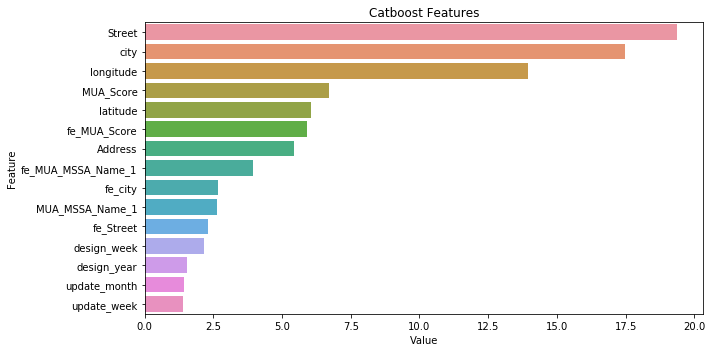

In [35]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), reverse=True)[:15], 
                           columns=['Value','Feature'])
plt.figure(figsize=(10,5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [36]:
acc = []
fold = KFold(n_splits=6, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_cv = X.loc[train_index], X.loc[test_index]
    y_train, y_cv = y[train_index], y[test_index]
    
    clf = CatBoostClassifier(iterations=1500, 
                         learning_rate=0.04,
                         loss_function='MultiClass', 
                         eval_metric='Accuracy', 
                         depth=6,
                         random_seed=42, 
                         od_type='Iter', 
                         )
    clf.fit(X_train, y_train,
            use_best_model=True,
            eval_set=[(X_cv, y_cv)], 
            verbose=50, early_stopping_rounds=25, 
            cat_features=cat_cols)

    y_preds = clf.predict(X_cv)
    print("Accuracy: ", accuracy_score(y_cv,y_preds))

    acc.append(accuracy_score(y_cv,y_preds))

0:	learn: 0.6871145	test: 0.6933181	best: 0.6933181 (0)	total: 140ms	remaining: 3m 30s
50:	learn: 0.9421979	test: 0.9434609	best: 0.9434609 (50)	total: 6.34s	remaining: 3m
100:	learn: 0.9771533	test: 0.9760137	best: 0.9760137 (100)	total: 12.6s	remaining: 2m 54s
150:	learn: 0.9837788	test: 0.9817247	best: 0.9817247 (147)	total: 19.6s	remaining: 2m 55s
200:	learn: 0.9891478	test: 0.9851513	best: 0.9851513 (197)	total: 26.5s	remaining: 2m 51s
250:	learn: 0.9925748	test: 0.9880069	best: 0.9880069 (245)	total: 33.6s	remaining: 2m 47s
300:	learn: 0.9944026	test: 0.9960023	best: 0.9960023 (300)	total: 41.2s	remaining: 2m 43s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.9960022844
bestIteration = 300

Shrink model to first 301 iterations.
Accuracy:  0.9960022844089091
0:	learn: 0.6909984	test: 0.6956025	best: 0.6956025 (0)	total: 127ms	remaining: 3m 10s
50:	learn: 0.9517935	test: 0.9611650	best: 0.9611650 (50)	total: 6.26s	remaining: 2m 57s
100:	learn: 0.9718986	test: 0

In [37]:
np.mean(acc,0)

0.9920042424736885